In [10]:
import pandas as pd

df = pd.read_csv("/content/btc_usd.csv")

df.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
1,Date,NaN,NaN,NaN,NaN,NaN
2,2015-01-01,314.2489929199219,320.43499755859375,314.00299072265625,320.43499755859375,8036550
3,2015-01-02,315.0320129394531,315.8389892578125,313.56500244140625,314.0790100097656,7860650
4,2015-01-03,281.0820007324219,315.1499938964844,281.0820007324219,314.84600830078125,33054400


In [11]:
import pandas as pd

df_raw = pd.read_csv("/content/btc_usd.csv")


if "Price" in df_raw.columns:
    df_raw = df_raw.rename(columns={"Price": "Date"})


df_clean = df_raw[df_raw["Date"].str.match(r"\d{4}-\d{2}-\d{2}", na=False)]


df_clean["Date"] = pd.to_datetime(df_clean["Date"])


for col in df_clean.columns:
    if col != "Date":
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

df_clean = df_clean.set_index("Date")

df_clean.head()

/tmp/ipython-input-4038340813.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Date"] = pd.to_datetime(df_clean["Date"])
/tmp/ipython-input-4038340813.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")


,Close,High,Low,Open,Volume
Date,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800


In [13]:

df = df_clean.copy()

df["SMA20"] = df["Close"].rolling(20).mean()
df["SMA50"] = df["Close"].rolling(50).mean()

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df["RSI14"] = compute_rsi(df["Close"])

df.dropna(inplace=True)


In [14]:
df["SMA20"] = df["Close"].rolling(20).mean()
df["SMA50"] = df["Close"].rolling(50).mean()

In [15]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df["RSI14"] = compute_rsi(df["Close"])

df.dropna(inplace=True)

In [17]:
import numpy as np


df["Position_GC"] = np.where(df["SMA20"] > df["SMA50"], 1, 0)


df["Returns"] = df["Close"].pct_change()


df["Strategy_GC"] = df["Position_GC"].shift(1) * df["Returns"]


df[["Close", "SMA20", "SMA50", "Position_GC", "Returns", "Strategy_GC"]].head()


,Close,SMA20,SMA50,Position_GC,Returns,Strategy_GC
Date,,,,,,
2015-04-09,243.675995,251.780150,260.615221,0,NaN,NaN
2015-04-10,236.072006,250.582500,260.531001,0,-0.031205,-0.0
2015-04-11,236.552002,249.012101,260.386461,0,0.002033,0.0
2015-04-12,236.153000,247.482751,260.218841,0,-0.001687,-0.0
2015-04-13,224.587006,246.432352,259.991041,0,-0.048977,-0.0


In [18]:
df["Position_RSI"] = np.where(df["RSI14"] < 30, 1,
                              np.where(df["RSI14"] > 70, -1, 0))

df["Strategy_RSI"] = df["Position_RSI"].shift(1) * df["Returns"]

In [19]:
df["Cumulative_BTC"] = (1 + df["Returns"]).cumprod()
df["Cumulative_GC"] = (1 + df["Strategy_GC"]).cumprod()
df["Cumulative_RSI"] = (1 + df["Strategy_RSI"]).cumprod()


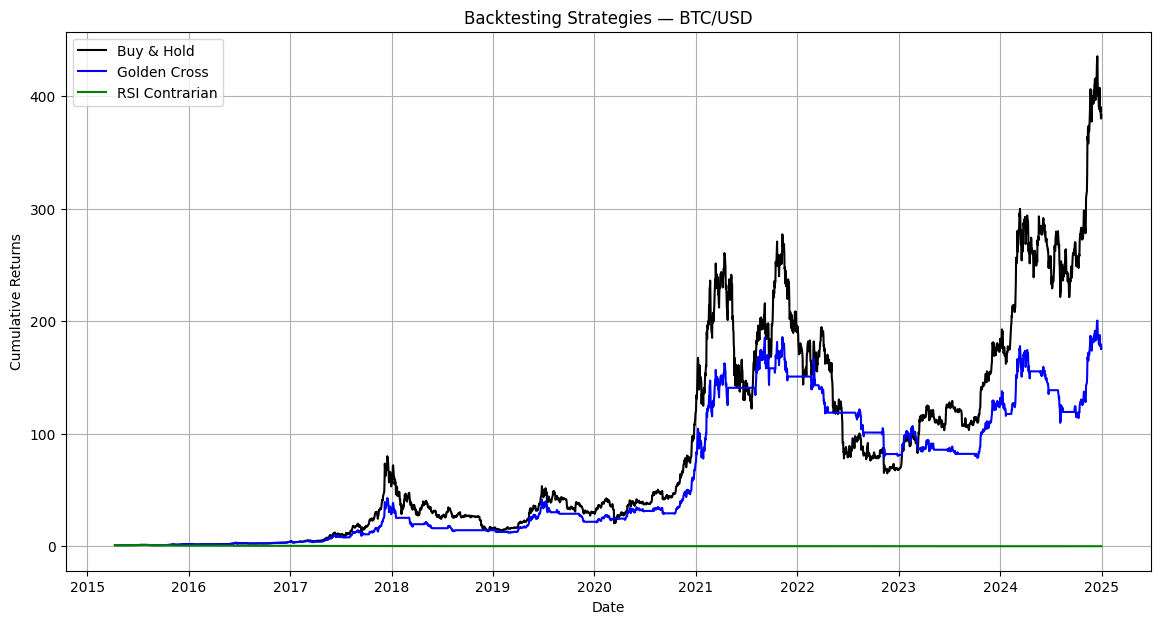

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(df.index, df["Cumulative_BTC"], label="Buy & Hold", color="black")
plt.plot(df.index, df["Cumulative_GC"], label="Golden Cross", color="blue")
plt.plot(df.index, df["Cumulative_RSI"], label="RSI Contrarian", color="green")
plt.title("Backtesting Strategies — BTC/USD")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
import numpy as np


def CAGR(cumulative_returns, periods_per_year=365):
    total_return = cumulative_returns.iloc[-1]
    n_periods = len(cumulative_returns)
    return (total_return ** (periods_per_year / n_periods)) - 1


def annual_volatility(returns, periods_per_year=365):
    return returns.std() * np.sqrt(periods_per_year)


def sharpe_ratio(returns, periods_per_year=365):
    return (returns.mean() / returns.std()) * np.sqrt(periods_per_year)

def max_drawdown(cumulative_returns):
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    return drawdown.min()

In [23]:
metrics = {}


metrics["Buy & Hold"] = {
    "CAGR": CAGR(df["Cumulative_BTC"]),
    "Volatility": annual_volatility(df["Returns"]),
    "Sharpe": sharpe_ratio(df["Returns"]),
    "Max Drawdown": max_drawdown(df["Cumulative_BTC"])
}


metrics["Golden Cross"] = {
    "CAGR": CAGR(df["Cumulative_GC"]),
    "Volatility": annual_volatility(df["Strategy_GC"]),
    "Sharpe": sharpe_ratio(df["Strategy_GC"]),
    "Max Drawdown": max_drawdown(df["Cumulative_GC"])
}


metrics["RSI Contrarian"] = {
    "CAGR": CAGR(df["Cumulative_RSI"]),
    "Volatility": annual_volatility(df["Strategy_RSI"]),
    "Sharpe": sharpe_ratio(df["Strategy_RSI"]),
    "Max Drawdown": max_drawdown(df["Cumulative_RSI"])
}


In [24]:
import pandas as pd

results = pd.DataFrame(metrics).T
results.style.format({
    "CAGR": "{:.2%}",
    "Volatility": "{:.2%}",
    "Sharpe": "{:.2f}",
    "Max Drawdown": "{:.2%}"
})

,CAGR,Volatility,Sharpe,Max Drawdown
Buy & Hold,84.19%,68.46%,1.24,-83.40%
Golden Cross,70.10%,52.29%,1.28,-72.11%
RSI Contrarian,-45.07%,44.72%,-1.11,-99.74%
